# Regression Models on Weekly Panel Curated




## Set Up and Data Loading

In [ ]:
# imports and setup
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
import itertools

# to read from drive files
from google.colab import drive
drive.mount('/content/drive')

# for graphs
import seaborn as sns
import matplotlib.pyplot as plt

Mounted at /content/drive


In [ ]:
# load data from drive

#you will need to update to your path
data_path = "/content/drive/MyDrive/olive_mvp_weekly_panel_curated - olive_mvp_weekly_panel_curated.csv"
# Patrick's path "/content/drive/MyDrive/olive_mvp_weekly_panel_curated - olive_mvp_weekly_panel_curated.csv"
# Rebecca's path "/content/drive/MyDrive/DATASCI210-Capstone/OpenSupplyChain_DATASCI210_Capstone/olive_mvp_weekly_panel_curated.csv"

df = pd.read_csv(data_path, parse_dates=["week_start"])
df.head()

,week_start,country,market,grade,price_eur_per_l,usd_per_eur,ocean_idx,diesel_usd_per_gal,ppi_glass,ppi_plastic_bottles,...,duty_cost,pack,pack_cost,ocean_uplift,diesel_uplift,deliv_hat_usd_per_l,duty_rate_adval,duty_specific_usd_per_kg,duty_specific_usd_per_l,z_base
0,2010-06-21,Italy,Bari,EVOO,2.46404,1.23236,-0.046658,2.961,129.4,140.5,...,0,glass,0.10352,-0.000933,0.002961,3.142132,NaN,NaN,NaN,-1.134324
1,2010-06-21,Italy,Bari,REFINED,1.67628,1.23236,-0.046658,2.961,129.4,140.5,...,0,plastic,0.08430,-0.000933,0.002961,2.152108,0.0,NaN,NaN,-0.679918
2,2010-06-21,Italy,Bari,VOO,1.90528,1.23236,-0.046658,2.961,129.4,140.5,...,0,glass,0.10352,-0.000933,0.002961,2.453539,NaN,NaN,NaN,-1.175108
3,2010-06-21,Italy,Brindisi,LAMPANTE,1.41064,1.23236,-0.046658,2.961,129.4,140.5,...,0,steel,0.19050,-0.000933,0.002961,1.930944,0.0,NaN,NaN,-0.887538
4,2010-06-21,Italy,Brindisi,VOO,1.74040,1.23236,-0.046658,2.961,129.4,140.5,...,0,glass,0.10352,-0.000933,0.002961,2.250347,NaN,NaN,NaN,-1.016500


In [ ]:
df.isna().sum()

,0
week_start,0
country,0
market,0
grade,0
price_eur_per_l,0
usd_per_eur,0
ocean_idx,0
diesel_usd_per_gal,0
ppi_glass,0
ppi_plastic_bottles,0


## Linear Regression
#### to get a sense of what variables matter

In [ ]:
df = df.sort_values("week_start").dropna(subset=["base_usd_per_l"])
df = df[df["base_usd_per_l"] > 0]

In [ ]:
# Basic regression
# not very informative as there is strong auto-correlation and we should do a baseline as a time series
# but gives us a sense of how variables relate
formula = (
    "base_usd_per_l ~ ocean_idx + diesel_usd_per_gal + "
    "ppi_glass + ppi_plastic_bottles + ppi_steel + pack_cost + duty_rate +"
    "C(country) + C(grade) + C(market)"
)

model = smf.ols(formula=formula, data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         base_usd_per_l   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     6217.
Date:                Fri, 05 Dec 2025   Prob (F-statistic):               0.00
Time:                        14:33:33   Log-Likelihood:                -74497.
No. Observations:               49298   AIC:                         1.491e+05
Df Residuals:                   49246   BIC:                         1.496e+05
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

## SARIMA Model On Aggregated Weekly Data

In [ ]:
# standardize key drivers
def zscore(s):
    return (s - s.mean()) / s.std(ddof=0)

drivers = ["ocean_idx", "diesel_usd_per_gal", "ppi_glass", "ppi_plastic_bottles", "ppi_steel", "pack_cost"]
for col in drivers:
    df[f"z_{col}"] = zscore(df[col])

In [ ]:
# create new column
df["cost_pressure"] = (
    0.4 * zscore(df["ocean_idx"]) +
    0.3 * zscore(df["diesel_usd_per_gal"]) +
    0.3 * zscore(df["pack_cost"])
)

In [ ]:
# group weekly and resample
# this removes any nuance from types of Olive Oil and Regions
weekly = (
    df.groupby("week_start", as_index=True)[["base_usd_per_l", "cost_pressure"]]
      .mean()
      # Resample to weekly frequency, taking the mean for weeks with multiple entries
      .resample("W")
      .mean()
      .interpolate() # Keep interpolate to fill any remaining gaps
)

In [ ]:
weekly.isna().any()

,0
base_usd_per_l,False
cost_pressure,False


In [ ]:
# SARIMA forecast

model_ts = SARIMAX(
    weekly["base_usd_per_l"],
    exog=weekly[["cost_pressure"]],
    order=(1, 1, 1),
    seasonal_order=(0, 1, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model_ts.fit(disp=False)
forecast_steps = 12
# Repeat the last row of the exogenous variables for forecasting
exog_forecast = pd.concat([weekly[["cost_pressure"]].iloc[-1:]] * forecast_steps, ignore_index=True)
pred = results.get_forecast(steps=forecast_steps, exog=exog_forecast)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

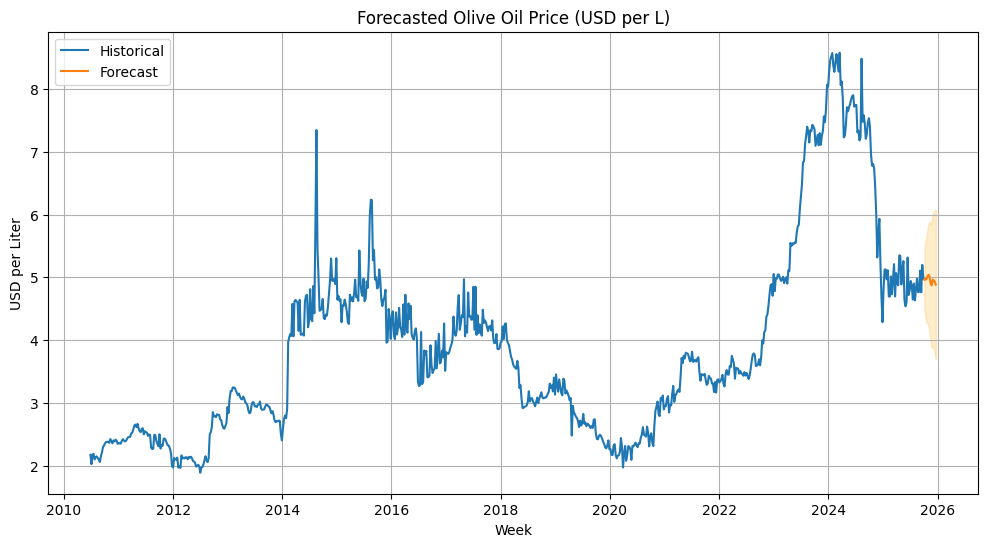

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(weekly.index, weekly["base_usd_per_l"], label="Historical")
plt.plot(pd.date_range(weekly.index[-1], periods=forecast_steps+1, freq="W")[1:], pred_mean, label="Forecast", color="tab:orange")
plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color="orange", alpha=0.2)
plt.title("Forecasted Olive Oil Price (USD per L)")
plt.ylabel("USD per Liter")
plt.xlabel("Week")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# inspect the forecast
# create price flag for larger weekly price changes
weekly["price_change"] = weekly["base_usd_per_l"].diff()
weekly["price_flag"] = (weekly["price_change"] > 0.05).astype(int)
weekly.tail(10)[["base_usd_per_l", "cost_pressure", "price_change", "price_flag"]]

,base_usd_per_l,cost_pressure,price_change,price_flag
week_start,,,,
2025-07-27,4.899510,0.197507,0.254919,1
2025-08-03,4.633842,0.215374,-0.265668,0
2025-08-10,4.816312,0.156190,0.182470,1
2025-08-17,4.977659,0.124957,0.161347,1
2025-08-24,4.761814,0.109929,-0.215845,0
2025-08-31,4.770339,0.102674,0.008525,0
2025-09-07,5.106753,0.110834,0.336413,1
2025-09-14,4.760320,0.129268,-0.346433,0
2025-09-21,5.197447,0.112637,0.437127,1


##SARIMA Backtesting Model

In [ ]:
#Build backtesting model for evaluation
train_bt = weekly.iloc[:-12]
test_bt = weekly.iloc[-12:]

model_bt = SARIMAX(
    train_bt["base_usd_per_l"],
    exog=train_bt[["cost_pressure"]],
    order=(1, 1, 1),
    seasonal_order=(0, 1, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results_bt = model_bt.fit(disp=False)

# Forecast last 12 weeks of data
pred_bt = results_bt.get_forecast(steps=12, exog=test_bt[["cost_pressure"]])
pred_mean_bt = pred_bt.predicted_mean
pred_ci_bt = pred_bt.conf_int()


In [ ]:
#Generate accuracy metrics
actuals_bt = test_bt["base_usd_per_l"]
mae_bt = (actuals_bt - pred_mean_bt).abs().mean()
rmse_bt = np.sqrt(((actuals_bt - pred_mean_bt) ** 2).mean())

print(f"Mean Absolute Error (MAE): {mae_bt}")
print(f"Root Mean Squared Error (RMSE): {rmse_bt}")

Mean Absolute Error (MAE): 0.19355954834321443
Root Mean Squared Error (RMSE): 0.24453087401549134


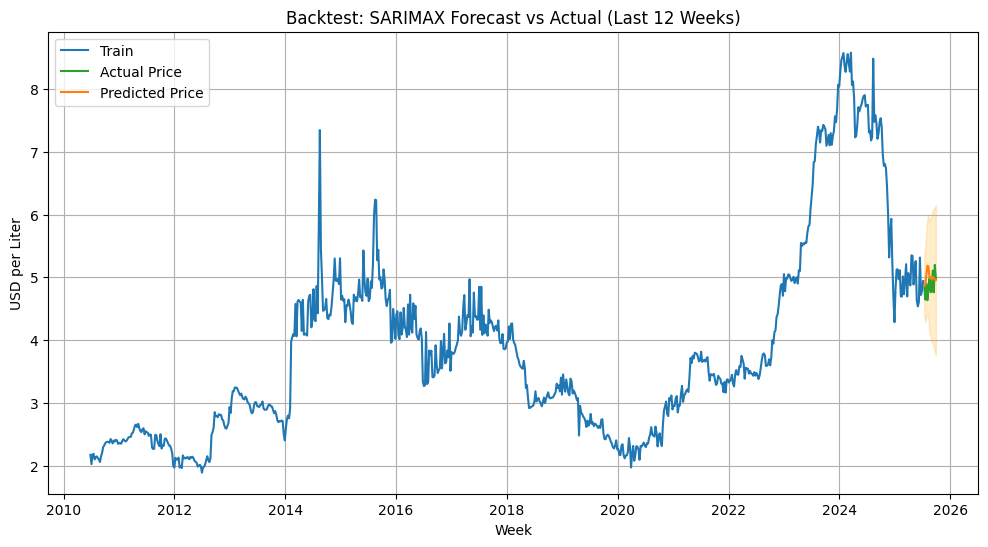

In [ ]:
#Plot actual values vs predicted values
plt.figure(figsize=(12,6))
plt.plot(train_bt.index, train_bt["base_usd_per_l"], label="Train", color="tab:blue")
plt.plot(test_bt.index, actuals_bt, label="Actual Price", color="tab:green")
plt.plot(test_bt.index, pred_mean_bt, label="Predicted Price", color="tab:orange")
plt.fill_between(test_bt.index, pred_ci_bt.iloc[:,0], pred_ci_bt.iloc[:,1], color="orange", alpha=0.2)
plt.title("Backtest: SARIMAX Forecast vs Actual (Last 12 Weeks)")
plt.xlabel("Week")
plt.ylabel("USD per Liter")
plt.legend()
plt.grid(True)
plt.show()

##SARIMA Grid Search

In [ ]:
#Run grid search on backtested and fine-tuned SARIMA model
train_grid = weekly.iloc[:-forecast_steps]
test_grid  = weekly.iloc[-forecast_steps:]

p = q = range(0, 2)
P = Q = range(0, 2)
d = D = 1
m = 52

param_grid = list(itertools.product(p, [d], q, P, [D], Q))

best_mae = float("inf")
best_order = None
best_seasonal = None
best_model = None

for (pi, di, qi, Pi, Di, Qi) in param_grid:
    order = (pi, di, qi)
    seasonal_order = (Pi, Di, Qi, m)
    try:
        model_grid = SARIMAX(
            train_grid["base_usd_per_l"],
            exog=train_grid[["cost_pressure"]],
            order=order,
            seasonal_order=seasonal_order,
            simple_differencing=False,
            concentrate_scale=True,
            enforce_stationarity=True,
            enforce_invertibility=True
        )
        results_grid = model_grid.fit(disp=False)

        pred_grid = results_grid.get_forecast(steps=forecast_steps, exog=test_grid[["cost_pressure"]])
        pred_mean_grid = pred_grid.predicted_mean

        mae_grid = (test_grid["base_usd_per_l"] - pred_mean_grid).abs().mean()

        print(f"Tested SARIMA{order}x{seasonal_order} → MAE: {mae_grid:.4f}")

        if mae_grid < best_mae:
            best_mae = mae_grid
            best_order = order
            best_seasonal = seasonal_order
            best_model = results_grid

    except Exception as e:
        print(f"Skipped SARIMA{order}x{seasonal_order} → {e}")
        continue

print("\nBest model found:")
print(f"Order: {best_order}, Seasonal Order: {best_seasonal}, MAE: {best_mae:.4f}")

Tested SARIMA(0, 1, 0)x(0, 1, 0, 52) → MAE: 0.3695
Tested SARIMA(0, 1, 0)x(0, 1, 1, 52) → MAE: 0.1959
Tested SARIMA(0, 1, 0)x(1, 1, 0, 52) → MAE: 0.3060
Tested SARIMA(0, 1, 0)x(1, 1, 1, 52) → MAE: 0.1885
Tested SARIMA(0, 1, 1)x(0, 1, 0, 52) → MAE: 0.3937
Tested SARIMA(0, 1, 1)x(0, 1, 1, 52) → MAE: 0.1919
Tested SARIMA(0, 1, 1)x(1, 1, 0, 52) → MAE: 0.2839
Tested SARIMA(0, 1, 1)x(1, 1, 1, 52) → MAE: 0.1855
Tested SARIMA(1, 1, 0)x(0, 1, 0, 52) → MAE: 0.3861
Tested SARIMA(1, 1, 0)x(0, 1, 1, 52) → MAE: 0.1925
Tested SARIMA(1, 1, 0)x(1, 1, 0, 52) → MAE: 0.2791
Tested SARIMA(1, 1, 0)x(1, 1, 1, 52) → MAE: 0.1860
Tested SARIMA(1, 1, 1)x(0, 1, 0, 52) → MAE: 0.3932
Tested SARIMA(1, 1, 1)x(0, 1, 1, 52) → MAE: 0.1927
Tested SARIMA(1, 1, 1)x(1, 1, 0, 52) → MAE: 0.2859
Tested SARIMA(1, 1, 1)x(1, 1, 1, 52) → MAE: 0.1858

Best model found:
Order: (0, 1, 1), Seasonal Order: (1, 1, 1, 52), MAE: 0.1855


In [ ]:
#Forecast last 12 weeks
pred_best_grid = best_model.get_forecast(steps=forecast_steps, exog=test_grid[["cost_pressure"]])
pred_mean_best_grid = pred_best_grid.predicted_mean
pred_ci_best_grid = pred_best_grid.conf_int()

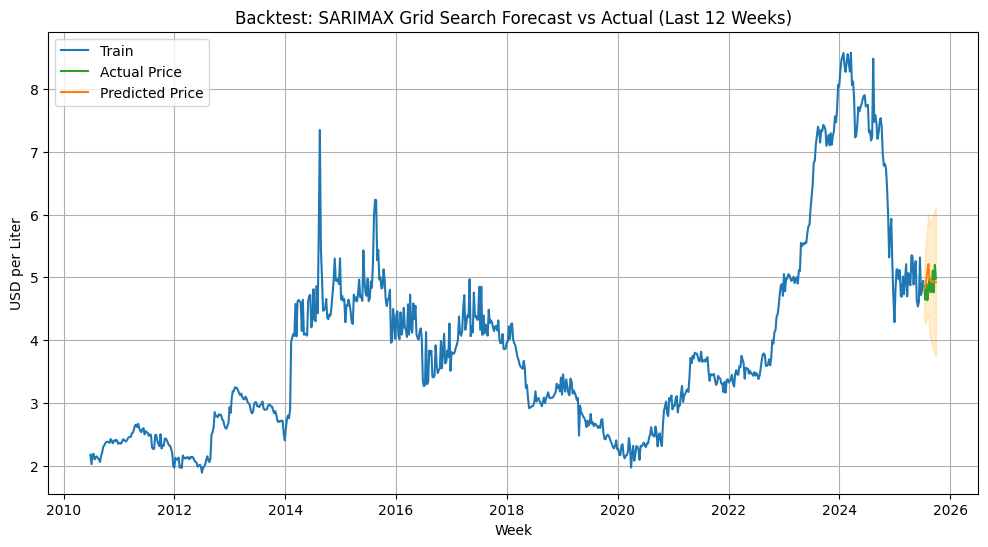

In [ ]:
#Plot actual values vs predicted values
plt.figure(figsize=(12,6))
plt.plot(train_grid.index, train_grid["base_usd_per_l"], label="Train", color="tab:blue")
plt.plot(test_grid.index, test_grid["base_usd_per_l"], label="Actual Price", color="tab:green")
plt.plot(test_grid.index, pred_mean_best_grid, label="Predicted Price", color="tab:orange")
plt.fill_between(test_grid.index, pred_ci_best_grid.iloc[:,0], pred_ci_best_grid.iloc[:,1], color="orange", alpha=0.2)
plt.title("Backtest: SARIMAX Grid Search Forecast vs Actual (Last 12 Weeks)")
plt.xlabel("Week")
plt.ylabel("USD per Liter")
plt.legend()
plt.grid(True)
plt.show()

## Temporal Ridge Regression Model

In [ ]:
#create lag and rolling features to better capture past trends
weekly['lag1week'] = weekly['base_usd_per_l'].shift(1)
weekly['lag2week'] = weekly['base_usd_per_l'].shift(2)
weekly['rolling3'] = weekly['base_usd_per_l'].rolling(3).mean()
weekly['rolling10'] = weekly['base_usd_per_l'].rolling(10).mean()

In [ ]:
#create temporal variables to capture seasonal variability
weekly['month'] = weekly.index.month
weekly['dayofweek'] = weekly.index.dayofweek
weekly['quarter'] = weekly.index.quarter
weekly.head()

,base_usd_per_l,cost_pressure,price_change,price_flag,lag1week,lag2week,rolling3,rolling10,month,dayofweek,quarter
week_start,,,,,,,,,,,
2010-06-27,2.171356,-0.357054,NaN,0,NaN,NaN,NaN,NaN,6,6,2
2010-07-04,2.022981,-0.398917,-0.148375,0,2.171356,NaN,NaN,NaN,7,6,3
2010-07-11,2.174778,-0.416095,0.151796,1,2.022981,2.171356,2.123038,NaN,7,6,3
2010-07-18,2.187627,-0.395888,0.012850,0,2.174778,2.022981,2.128462,NaN,7,6,3
2010-07-25,2.097929,-0.382300,-0.089698,0,2.187627,2.174778,2.153445,NaN,7,6,3


In [ ]:
#create train and test groups
temp_features = ['lag1week', 'lag2week', 'rolling3', 'rolling10', 'month', 'dayofweek', 'quarter', 'cost_pressure']
tempdf = weekly.dropna(subset=temp_features + ['base_usd_per_l'])
X = tempdf[temp_features]
y = tempdf['base_usd_per_l']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=12, shuffle=False)

In [ ]:
#train model and make predictions
temp_model = Ridge(alpha=1.0)
temp_model.fit(X_train, y_train)
temp_pred = temp_model.predict(X_test)

pred_mean_temp = temp_pred

In [ ]:
#generate accuracy metrics
mae_temp = (y_test - temp_pred).abs().mean()
rmse_temp = np.sqrt(((y_test - temp_pred) ** 2).mean())

print(f"Mean Absolute Error (MAE): {mae_temp}")
print(f"Root Mean Squared Error (RMSE): {rmse_temp}")

Mean Absolute Error (MAE): 0.03931089457149114
Root Mean Squared Error (RMSE): 0.0449475380945638


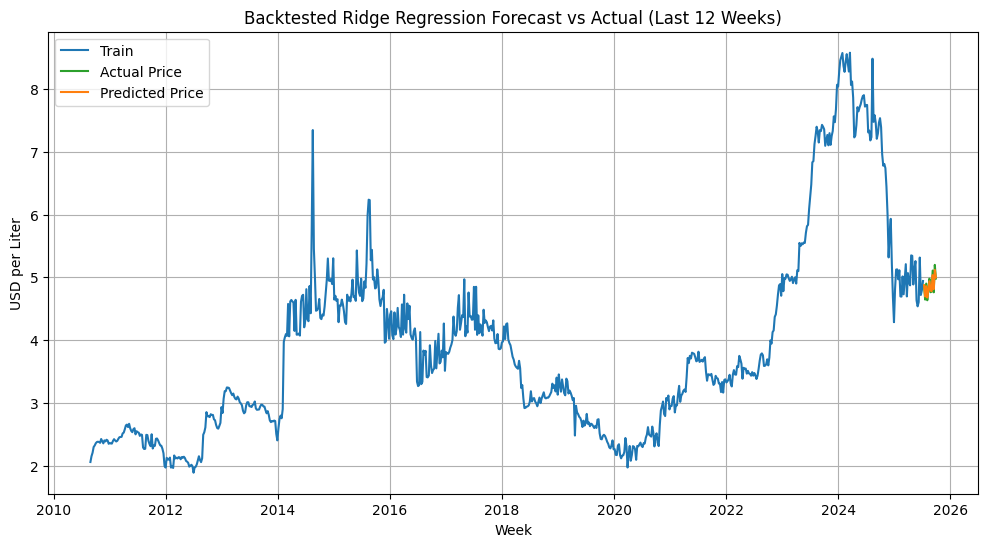

In [ ]:
#Plot actual values vs predicted values
plt.figure(figsize=(12,6))
plt.plot(X_train.index, y_train, label="Train", color="tab:blue")
plt.plot(X_test.index, y_test, label="Actual Price", color="tab:green")
plt.plot(X_test.index, pred_mean_temp, label="Predicted Price", color="tab:orange")
plt.title("Backtested Ridge Regression Forecast vs Actual (Last 12 Weeks)")
plt.xlabel("Week")
plt.ylabel("USD per Liter")
plt.legend()
plt.grid(True)
plt.show()

##Fine-Tuned Ridge Regression Model

In [ ]:
#create lag and rolling features to better capture past trends
weekly['lag1week'] = weekly['base_usd_per_l'].shift(1)
weekly['lag2week'] = weekly['base_usd_per_l'].shift(2)
weekly['rolling3'] = weekly['base_usd_per_l'].rolling(3).mean()
weekly['rolling10'] = weekly['base_usd_per_l'].rolling(10).mean()

#create temporal variables to capture seasonal variability
weekly['month'] = weekly.index.month
weekly['dayofweek'] = weekly.index.dayofweek
weekly['quarter'] = weekly.index.quarter

In [ ]:
#add seasonality feature to weekly data
weekly['sin_week'] = np.sin(2 * np.pi * weekly.index.isocalendar().week / 52)

In [ ]:
#create train and test groups
temp_features = ['lag1week', 'lag2week', 'rolling3', 'rolling10', 'month', 'dayofweek', 'quarter', 'cost_pressure', 'sin_week']
tempdf = weekly.dropna(subset=temp_features + ['base_usd_per_l'])
X = tempdf[temp_features]
y = tempdf['base_usd_per_l']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, shuffle=False)

In [ ]:
#train models with different alpha values using RidgeCV for fine-tuning
alphas = np.logspace(-3, 3, 20)

ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train, y_train)

cv_pred = ridge_cv.predict(X_test)

mae_cv = (y_test - cv_pred).abs().mean()
rmse_cv = np.sqrt(((y_test - cv_pred) ** 2).mean())

print(f"Mean Absolute Error (MAE): {mae_cv}")
print(f"Root Mean Squared Error (RMSE): {rmse_cv}")

Mean Absolute Error (MAE): 7.006448911102136e-05
Root Mean Squared Error (RMSE): 9.844751665830947e-05


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


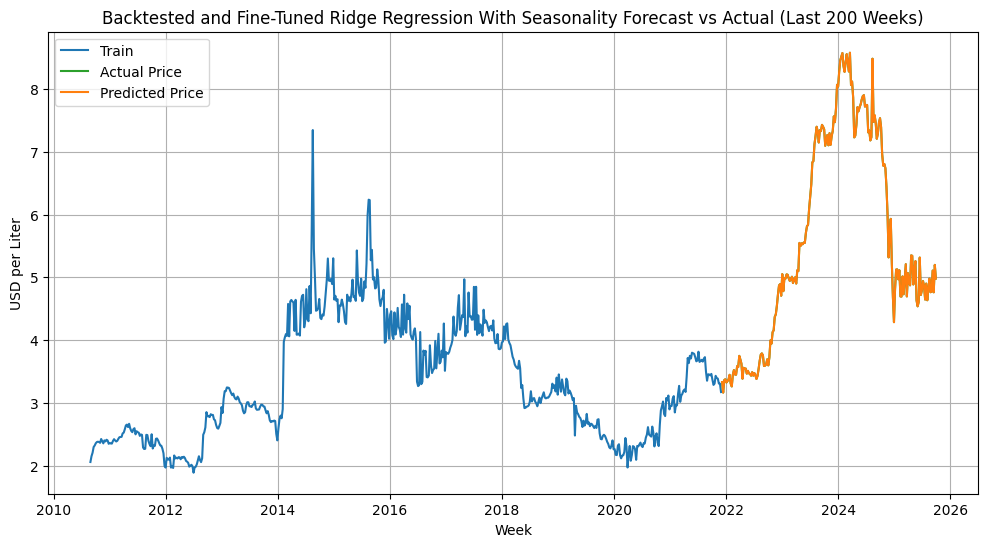

In [ ]:
#Plot actual values vs predicted values
plt.figure(figsize=(12,6))
plt.plot(X_train.index, y_train, label="Train", color="tab:blue")
plt.plot(X_test.index, y_test, label="Actual Price", color="tab:green")
plt.plot(X_test.index, cv_pred, label="Predicted Price", color="tab:orange")
plt.title("Backtested and Fine-Tuned Ridge Regression With Seasonality Forecast vs Actual (Last 200 Weeks)")
plt.xlabel("Week")
plt.ylabel("USD per Liter")
plt.legend()
plt.grid(True)
plt.show()